In [15]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

print("Running...")
toc = time.perf_counter()
#ALL SETUP

thr_std=0.2


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

tic = time.perf_counter()
print("All data loaded in", tic-toc, "seconds")

Running...
All data loaded in 60.25761539999985 seconds


In [32]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    #given plane and event number, extract required information and threshold if required
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

In [38]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)

    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0
def pick_xz(plane, event_number, i, thresholding=True, no_std=thr_std):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    return AoI_z[i], AoI_x[i]
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x
def rfunc(r):
    return 1/((0.01+r)**(1/2))

In [39]:
def rphi_score(plane, event_number, centre_coord, no_sectors=5, centre=0, r_dependence=rfunc, thresholding=True, no_std=thr_std):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    #centralise co-ordinates on the given point of interest
    
    centred_r = (centred_x**2 + centred_z**2)**0.5
    theta = np.arctan2(centred_x, centred_z)
    #convert co-ordinates to polar
    
    weight = r_dependence(centred_r)
    #weighting varies with the polar radius in the manner described by rfunc
    
    hist_data, hist_bins = np.histogram(theta, bins=no_sectors, range=(-np.pi+centre,np.pi+centre), weights=weight)
    #plt.hist(theta, bins=no_sectors, range=(-np.pi+centre,np.pi+centre), weights=weight)
    #plt.show()
    #plt.bar(hist_data, np.delete(hist_bins,-1),align='edge')
    #plt.show()
    
    
    hist_data2 = (hist_data - np.roll(hist_data, int(len(hist_data)/2)))[hist_data>0]

    hist_sqr = hist_data2**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    return norm_score

In [40]:
def optimise_phi(plane, event_number, no_sectors=5, centre=0, r_dependence=rfunc, thresholding=True, no_std=thr_std, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = pick_xz(plane, event_number, i, thresholding, no_std)
        score_arr[i] = rphi_score(plane, event_number, centre_coord=centre_co, no_sectors=no_sectors, centre=0, r_dependence=r_dependence)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]

In [45]:
def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std, no_sectors=5):
    Zvert = []
    Zvert_true = []
    Xvert = []
    Xvert_true = []
    
    for i in tqdm(range(no_events)):
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
        Zvert_place, Xvert_place = function(plane, i, no_sectors)[0], function(plane, i, no_sectors)[1]
        Zvert.append(Zvert_place)
        Xvert.append(Xvert_place)
        Zvert_true.append(Zvert_true_place)
        Xvert_true.append(Xvert_true_place)
    
    #print(Zvert_true)
    #print(Zvert)
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2
    
    print(delta_r2)
    data, bins = np.histogram(delta_r2, 30)
    
    plt.hist(data, bins=10)
    plt.show()

    return delta_r2

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [12:36<00:00,  2.64it/s]

[ 4.298362    5.0254555   0.08282825 ... 70.79176     0.27311295
  1.9161332 ]


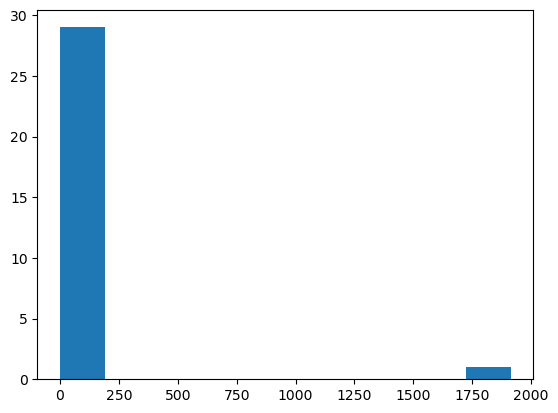

In [48]:
delta_r2 = accuracy("v", optimise_phi, 2000, no_sectors=5)

In [49]:
print(np.percentile(delta_r2, 68))

233.1807379150395


32.848529052734385


In [ ]:
'''
j = 0
x = []
x_ln = len(x)
x_dummy = x
for i in range(x_ln):
    j += 1
    if condition:
        remove value from x_dummy 
        j -= 1
    else:
        keep going

'''